In [1]:
!pwd

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

/content


In [ ]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification
!unzip /content/ham1000-segmentation-and-classification.zip

In [8]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-wjvrc2x5
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-wjvrc2x5
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=cf7c8254a12c7c78701e6a1593dc6f498716f81a723c77dad9a6a60b77ccb27c
  Stored in directory: /tmp/pip-ephem-wheel-cache-7k9t0cqw/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [52]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import Image

from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.pyplot import imshow

In [3]:
def undersample(df, count, rs=42):
  result=[]
  df_group = df.groupby('dx')
  for x in df['dx'].unique():
    group = df_group.get_group(x)
    num = int(group['dx'].value_counts())
    if num >= count:
      s=group.sample(count, axis=0, random_state=rs)
    else:
      s=group.sample(frac=1, axis=0, random_state=rs)
    result.append(s)
  return pd.concat(result, axis=0).reset_index(drop=True)

def oversample(df, count, rs=42):
  lst = [df]
  for class_index, group in df.groupby('dx'):
      lst.append(group.sample(count-len(group), replace=True, random_state=rs))
  df_new = pd.concat(lst)
  return df_new

def img_np_convert(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: np.asarray(Image.open(x).resize((h, w))).astype(np.float32))
  return df

def img_np_convert_scaled(df, image_path, h, w):
  df['image_id'] = image_path + df['image_id'] +'.jpg'
  df['image'] = df['image_id'].map(lambda x: (np.asarray(Image.open(x).resize((h, w)))/255).astype(np.float32))
  return df

def my_split(df, train_size, test_size, val_size, rs=42):
  valid_test_split = val_size / test_size

  df_train, df_test_val = train_test_split(df, test_size=1-train_size, shuffle=True, random_state=rs)
  df_val, df_test = train_test_split(df_test_val, test_size=valid_test_split, shuffle=True, random_state=rs)

  df_train.reset_index(inplace=True)
  return df_train, df_test, df_val

def weight_cal(df):
  class_weight={}
  labels = list(df['dx'].unique())
  labels.sort()
  count = df['dx'].value_counts()
  for idx in range(7):
    class_weight[idx] = count['nv']/count[labels[idx]]
  return class_weight, labels

def df_to_np1(df):
  image = np.asarray(df['image'].to_list()) 
  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return image, target

def df_to_np2(df):
  df['image'] = df['image'].map(lambda x : x.flatten())
  i_feature = np.asarray(df['image'].tolist())
  df_feature = df.iloc[:, 3:-1]
  c_feature = df_feature.loc[:, ~df_feature.columns.isin(['sex', 'dx'])].to_numpy()
  features = np.concatenate((i_feature, c_feature), axis=1)
  
  target_df = df['dx']
  target = pd.get_dummies(data=target_df, columns=['dx']).to_numpy()
  return features, target

def image_augment(df, target, count, size, rs=42):
  df_group = df.groupby('dx')
  group = df_group.get_group(target)
  s=group.sample(count, axis=0, random_state=rs)

  datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode='nearest')
  
  for index, row in s.iterrows():
    image = row['image'].reshape((1, ) + row['image'].shape)
    gen = datagen.flow(image, batch_size=size)
    input = row.to_list()
    for i in range(size):
      img = next(gen)
      input[-1] = img[0]
      df.loc[len(df.index)] = input
  return None

In [4]:
def prep_pipeline2(upper_size, h, w, aug_targets, aug_count, aug_size, rs=42):
  df_o = pd.read_csv('../content/drive/MyDrive/DSE_I2100/data/HAM10000_metadata.csv')
  df_o = pd.get_dummies(data=df_o, columns=['dx_type', 'localization'])
  image_path = r'../content/images/'
  df_u = undersample(df_o, upper_size)
  df_u['age'].fillna(value=int(df_u['age'].mean()), inplace=True)
  df_u['age'] = df_u['age'].astype(np.float32)

  df = img_np_convert_scaled(df_u, image_path, h, w)

  df_train, df_test, df_val = my_split(df, 0.7, 0.2, 0.1, rs)

  for target in aug_targets:
    image_augment(df_train, target, aug_count, aug_size, rs)

  weight, labels = weight_cal(df_train)

  X_train, y_train = df_to_np2(df_train)
  X_test, y_test = df_to_np2(df_test)
  X_val, y_val = df_to_np2(df_val)
  return (X_train, y_train), (X_test, y_test), (X_val, y_val), weight, labels

In [28]:
h = 90
w = 90
aug_targets = ['mel', 'bcc']
aug_count = 50
aug_size = 4
majority = 6000

train_set, test_set, val_set, class_weight, labels = prep_pipeline2(majority, h, w, aug_targets, aug_count, aug_size)

In [29]:
X_train = train_set[0]
y_train = np.argmax(train_set[1], axis=1)

X_val = val_set[0]
y_val = np.argmax(val_set[1], axis=1)

X_test = test_set[0]
y_test = np.argmax(test_set[1], axis=1)

In [30]:
print(X_train.shape, X_test.shape, X_val.shape)

(6916, 24320) (1397, 24320) (1397, 24320)


In [40]:
class_weight

{0: 18.57079646017699,
 1: 7.441489361702128,
 2: 5.529644268774703,
 3: 50.566265060240966,
 4: 4.260913705583756,
 5: 1.0,
 6: 41.14705882352941}

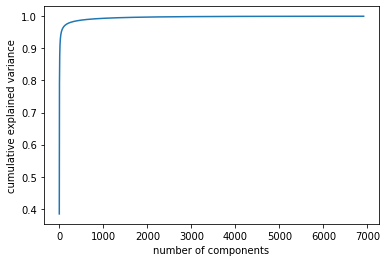

In [55]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [56]:
pca = PCA(n_components = 0.95).fit(X_train)


In [59]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

In [65]:
X_train_pca.shape

(6916, 47)

In [61]:
from sklearn.linear_model import RidgeClassifier
reg = RidgeClassifier(class_weight=class_weight)
reg.fit(X_train_pca, y_train)
print(reg.score(X_train_pca, y_train))
print(reg.score(X_val_pca, y_val))
print(reg.score(X_test_pca, y_test))

0.5895026026604974
0.5833929849677881
0.5740873299928418


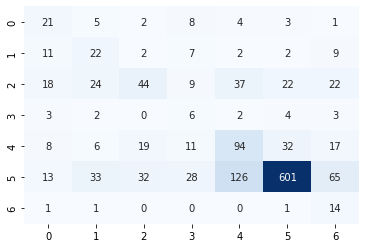

In [63]:
y_pred = reg.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False) 

In [64]:
clr = classification_report(y_test, y_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.28      0.48      0.35        44
         bcc       0.24      0.40      0.30        55
         bkl       0.44      0.25      0.32       176
          df       0.09      0.30      0.13        20
         mel       0.35      0.50      0.42       187
          nv       0.90      0.67      0.77       898
        vasc       0.11      0.82      0.19        17

    accuracy                           0.57      1397
   macro avg       0.34      0.49      0.35      1397
weighted avg       0.71      0.57      0.62      1397



In [66]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight=class_weight)
lr.fit(X_train_pca, y_train)
print(lr.score(X_train_pca, y_train))
print(lr.score(X_val_pca, y_val))
print(lr.score(X_test_pca, y_test))

0.601792943898207
0.5848246241947029
0.5805297065139585


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


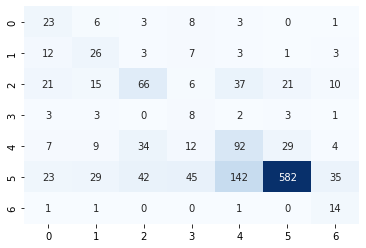

In [67]:
y_pred = lr.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)

In [68]:
clr = classification_report(y_test, y_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.26      0.52      0.34        44
         bcc       0.29      0.47      0.36        55
         bkl       0.45      0.38      0.41       176
          df       0.09      0.40      0.15        20
         mel       0.33      0.49      0.39       187
          nv       0.92      0.65      0.76       898
        vasc       0.21      0.82      0.33        17

    accuracy                           0.58      1397
   macro avg       0.36      0.53      0.39      1397
weighted avg       0.71      0.58      0.62      1397



In [69]:
from sklearn.svm import SVC
svc = SVC(gamma='auto', class_weight=class_weight)
svc.fit(X_train_pca, y_train)
print(svc.score(X_train_pca, y_train))
print(svc.score(X_val_pca, y_val))
print(svc.score(X_test_pca, y_test))

1.0
0.6821760916249106
0.6800286327845383


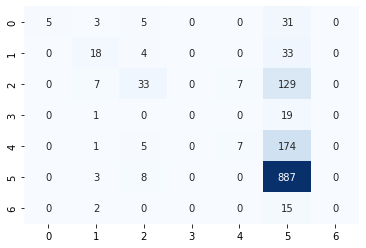

In [71]:
y_pred = svc.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)

In [72]:
clr = classification_report(y_test, y_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       1.00      0.11      0.20        44
         bcc       0.51      0.33      0.40        55
         bkl       0.60      0.19      0.29       176
          df       0.00      0.00      0.00        20
         mel       0.50      0.04      0.07       187
          nv       0.69      0.99      0.81       898
        vasc       0.00      0.00      0.00        17

    accuracy                           0.68      1397
   macro avg       0.47      0.24      0.25      1397
weighted avg       0.64      0.68      0.59      1397



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=6, random_state=0, class_weight=class_weight)
rf.fit(X_train_pca, y_train)
print(rf.score(X_train_pca, y_train))
print(rf.score(X_val_pca, y_val))
print(rf.score(X_test_pca, y_test))

0.7343840370156159
0.6635647816750179
0.6463851109520401


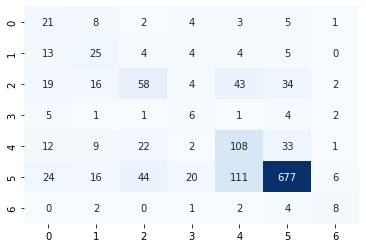

In [74]:
y_pred = rf.predict(X_test_pca)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)

In [75]:
clr = classification_report(y_test, y_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

       akiec       0.22      0.48      0.30        44
         bcc       0.32      0.45      0.38        55
         bkl       0.44      0.33      0.38       176
          df       0.15      0.30      0.20        20
         mel       0.40      0.58      0.47       187
          nv       0.89      0.75      0.82       898
        vasc       0.40      0.47      0.43        17

    accuracy                           0.65      1397
   macro avg       0.40      0.48      0.43      1397
weighted avg       0.71      0.65      0.67      1397

